# Hitmap for channel utilization

In [2]:
import pandas as pd
from collections import Counter
import re
import os
from random_access.configs import simulation_configs

In [6]:
df_temp = pd.read_pickle("pickle/obss_simulation_s0_2_fshort_npca_1.pkl")
# Find row index where states_ch_1 includes "npca_transmitting"
# row_index = df_temp[df_temp['states_ch_1'].apply(lambda x: 'npca_transmitting' in x)].index
df_temp.head()
df_temp.to_csv("temp.csv", index=False)

In [ ]:
# ✅ STA 성공 횟수 계산 함수
def get_successful_stas(df, channel=0):
    col_backoff = f'backoff_ch_{channel}'
    col_state = f'states_ch_{channel}'

    success_counter = Counter()

    for _, row in df.iterrows():
        backoffs = row[col_backoff]
        states = row[col_state]

        if backoffs.count(0) == 1:
            idx = backoffs.index(0)
            if states[idx] == 'primary_transmitting':
                success_counter[idx] += 1

    simulation_time = len(df)
    throughput = pd.Series(success_counter).sort_index() / simulation_time
    return throughput

# ✅ Jain's Fairness Index 계산 함수
def get_jain_index(df, channel=0):
    sta_tp = get_successful_stas(df, channel=channel)
    if len(sta_tp) == 0 or sta_tp.mean() == 0:
        return float('nan')
    return (sta_tp.sum())**2 / (len(sta_tp) * (sta_tp**2).sum())

# ✅ 채널 utilization 계산 함수
def get_channel_utilization(df):
    utilization = []
    for ch in ['0', '1']:
        backoff_condition = df[f'backoff_ch_{ch}'].apply(lambda x: x.count(0) == 1)
        utilization.append(
            df[backoff_condition][f'channel_{ch}_occupied_until'].astype(bool).sum() / len(df)
        )
    return utilization

# ✅ 결과 누적 리스트
records = []

for config in simulation_configs:
    label = config['label'].replace(' ', '_').lower()
    pkl_file = f"pickle/obss_simulation_{label}.pkl"

    if not os.path.exists(pkl_file):
        print(f"❗ 파일 없음: {pkl_file}")
        continue
    
    # ✅ 한 번만 로딩
    df = pd.read_pickle(pkl_file)
    print(f"Loaded {label} with {len(df)} rows.")

    # ✅ 각 지표 계산
    util_ch0, util_ch1 = get_channel_utilization(df)
    fairness_ch0 = get_jain_index(df, channel=0)
    fairness_ch1 = get_jain_index(df, channel=1)

    # ✅ 메타데이터 추출 및 기록
    match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d)', label)
    if match:
        records.append({
            "label": label,
            "ch0": int(match.group(1)),
            "ch1": int(match.group(2)),
            "frame": match.group(3),
            "npca": int(match.group(4)),
            "util_ch0": util_ch0,
            "util_ch1": util_ch1,
            "fairness_ch0": fairness_ch0,
            "fairness_ch1": fairness_ch1
        })

    del df  # 메모리 해제

# ✅ 최종 결과 저장
df_metrics = pd.DataFrame(records)
df_metrics.to_csv("combined_metrics_summary.csv", index=False)


Loaded s2_2_fshort_npca_1 with 100000 rows.
Loaded s2_2_fshort_npca_0 with 100000 rows.
Loaded s2_2_flong_npca_1 with 100000 rows.
Loaded s2_2_flong_npca_0 with 100000 rows.


In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.size": 24,           # 글꼴 크기
    "lines.linewidth": 2.5,    # 선 굵기 ← 이 줄 추가
    "lines.markersize": 8      # 마커 크기도 같이 조절 가능 (선택)
})
df_util = pd.read_csv("combined_metrics_summary.csv")

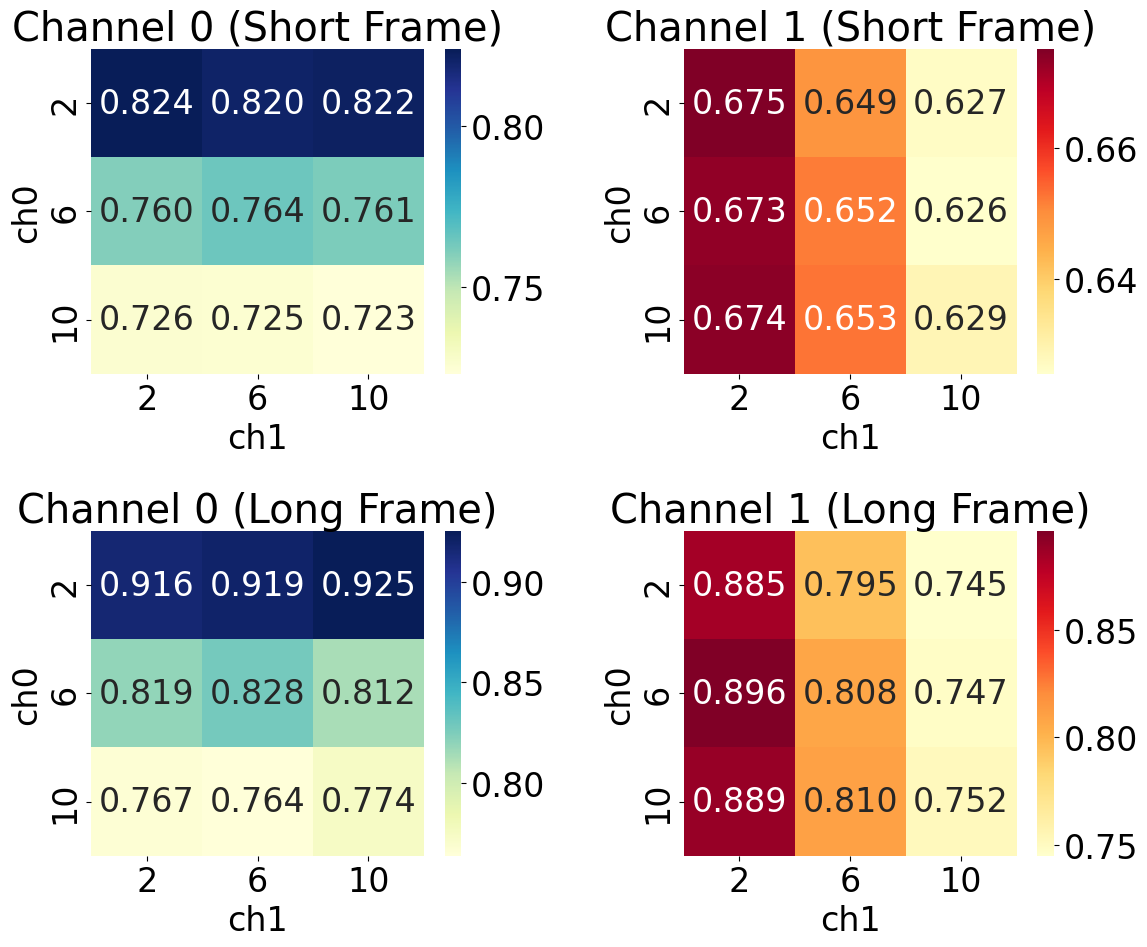

In [5]:
# NPCA OFF
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 0)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 0)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Long Frame)")

plt.tight_layout()
plt.savefig("plots/npca_off_channel_utilization.png")


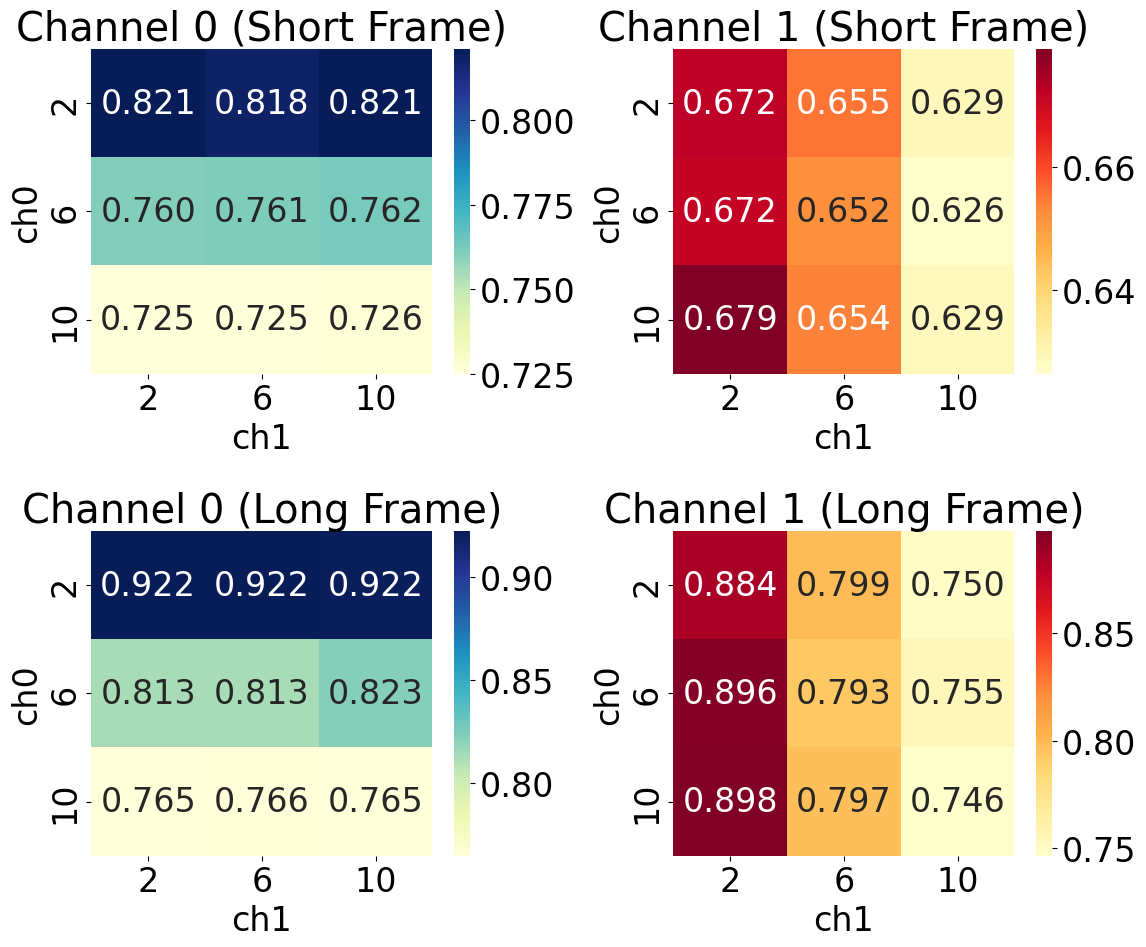

In [7]:
# NPCA ON
df_short = df_util[(df_util["frame"] == "short") & (df_util["npca"] == 1)]
df_long = df_util[(df_util["frame"] == "long") & (df_util["npca"] == 1)]

pivot_ch0_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_short = df_short.pivot(index="ch0", columns="ch1", values="util_ch1")
pivot_ch0_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch0")
pivot_ch1_long = df_long.pivot(index="ch0", columns="ch1", values="util_ch1")


# 히트맵 시각화
plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
sns.heatmap(pivot_ch0_short, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Short Frame)")

plt.subplot(2, 2, 2)
sns.heatmap(pivot_ch1_short, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Short Frame)")

plt.subplot(2, 2, 3)
sns.heatmap(pivot_ch0_long, annot=True, cmap="YlGnBu", fmt=".3f")
plt.title("Channel 0 (Long Frame)")

plt.subplot(2, 2, 4)
sns.heatmap(pivot_ch1_long, annot=True, cmap="YlOrRd", fmt=".3f")
plt.title("Channel 1 (Long Frame)")

plt.tight_layout()
plt.savefig("plots/npca_on_channel_utilization.png")


# Tput per each STA

In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import seaborn as sns
# import ast
# import re
# from collections import Counter
# import os
# from random_access.configs import simulation_configs

# # Step 1: 데이터프레임들 불러오기
# labels = [config["label"] for config in simulation_configs]
# dataframes = {
#     label: pd.read_csv(f"csv/obss_simulation_{label}.csv") for label in labels
# }

# # Step 2: 성공 횟수 계산 함수
# def get_successful_stas(label, channel=0):
#     df = dataframes[label]
#     col_backoff = f'backoff_ch_{channel}'
#     col_state = f'states_ch_{channel}'
    
#     success_counter = Counter()
    
#     for _, row in df.iterrows():
#         backoffs = ast.literal_eval(row[col_backoff])
#         states = ast.literal_eval(row[col_state])
#         if backoffs.count(0) == 1:
#             idx = backoffs.index(0)
#             if states[idx] == 'primary_transmitting':
#                 success_counter[idx] += 1
#     return pd.Series(success_counter).sort_index()

# # Step 3: Jain 지수 계산
# def get_jain_index(label, channel=0):
#     sta_tp = get_successful_stas(label, channel=channel)
#     mean_tp = sta_tp.mean()
#     if mean_tp == 0:
#         return float('inf')
#     return (sta_tp.sum())**2 / (len(sta_tp) * (sta_tp**2).sum())

# # Step 4: Label 파싱
# def parse_label(label):
#     match = re.match(r's(\d+)_(\d+)_f(short|long)_npca_(\d+)', label)
#     if match:
#         return {
#             "ch0": int(match.group(1)),
#             "ch1": int(match.group(2)),
#             "frame": match.group(3),
#             "npca": int(match.group(4))
#         }

# # Step 5: Jain 지수 수집
# records = []
# for label in dataframes:
#     meta = parse_label(label)
#     for ch in [0, 1]:
#         fairness = get_jain_index(label, channel=ch)
#         records.append({
#             "label": label,
#             "ch0": meta["ch0"],
#             "ch1": meta["ch1"],
#             "frame": meta["frame"],
#             "npca": meta["npca"],
#             "channel": ch,
#             "fairness": fairness
#         })
# df_fairness = pd.DataFrame(records)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


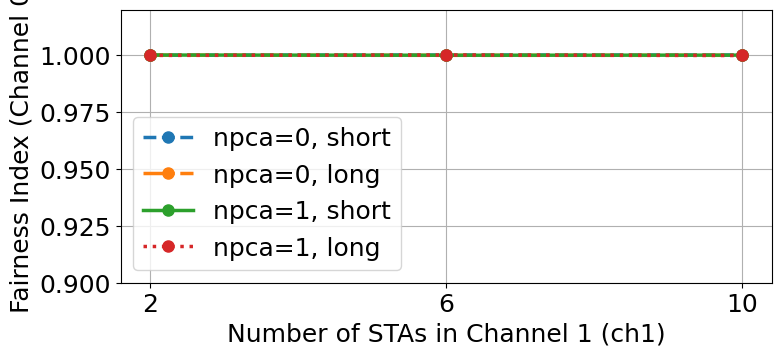

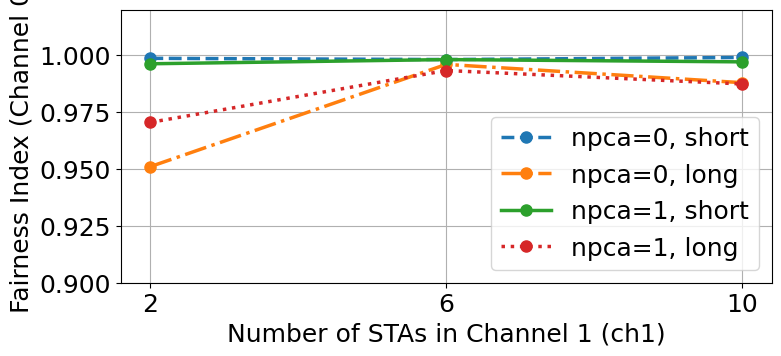

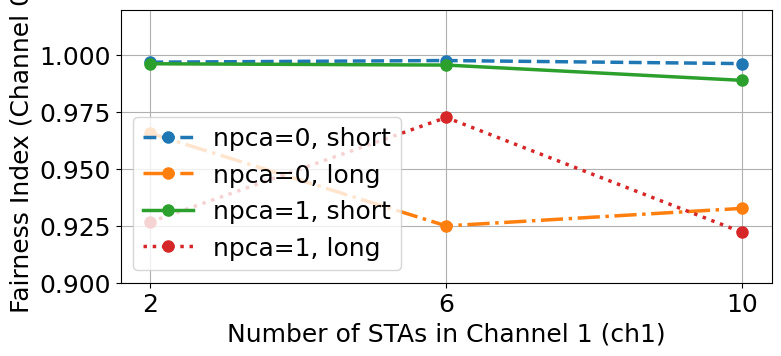

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.size": 18,           # 글꼴 크기
    "lines.linewidth": 2.5,    # 선 굵기 ← 이 줄 추가
    "lines.markersize": 8      # 마커 크기도 같이 조절 가능 (선택)
})

df_fairness = pd.read_csv("combined_metrics_summary.csv")

# Step 6: Plotting (Channel 0 기준)
colors = {2: 'blue', 6: 'green', 10: 'red'}
styles = {
    0: {"short": "dashed", "long": "dashdot"},
    1: {"short": "solid", "long": "dotted"},
}

# 유일한 ch0 값 목록
unique_ch0_values = sorted(df_fairness["ch0"].unique())

# 각 ch0 값에 대해 개별 plot 출력
for ch0_val in unique_ch0_values:
    fig, ax = plt.subplots(figsize=(8, 4))

    for npca in [0, 1]:
        for frame in ["short", "long"]:
            subset = df_fairness[
                (df_fairness["ch0"] == ch0_val) &
                (df_fairness["npca"] == npca) &
                (df_fairness["frame"] == frame)
            ].sort_values("ch1")
            if not subset.empty:
                label = f"npca={npca}, {frame}"
                ax.plot(subset["ch1"], subset["fairness_ch0"],
                        label=label,
                        linestyle=styles[npca][frame],
                        marker='o')
    ax.set_xticks(subset["ch1"].unique())
    # ax.set_title(f"Jain's Fairness Index on Channel 0\n(STA in ch0 = {ch0_val})")
    ax.set_xlabel("Number of STAs in Channel 1 (ch1)")
    ax.set_ylabel("Fairness Index (Channel 0)")
    ax.set_ylim(0.9, 1.02)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"plots/jain_fairness_ch0_{ch0_val}.eps")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


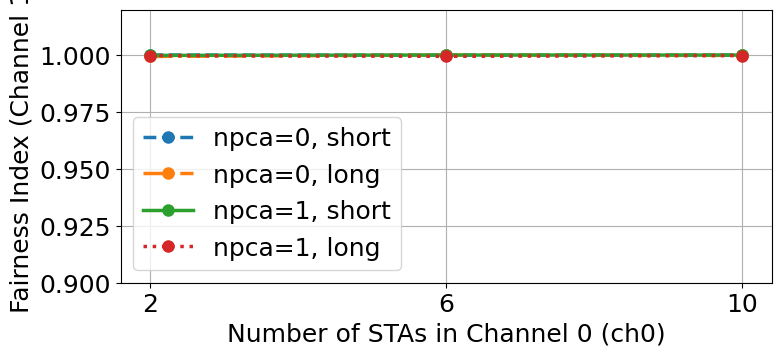

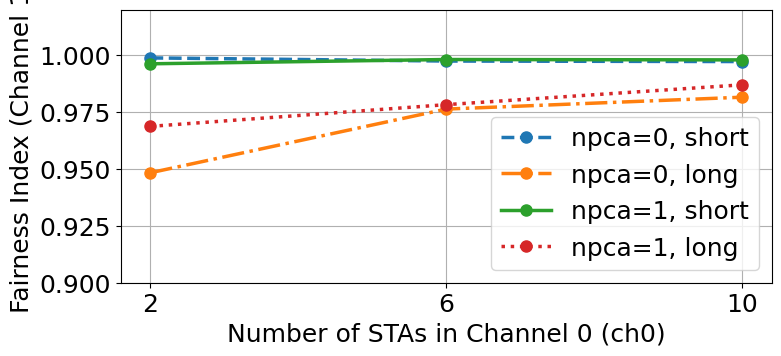

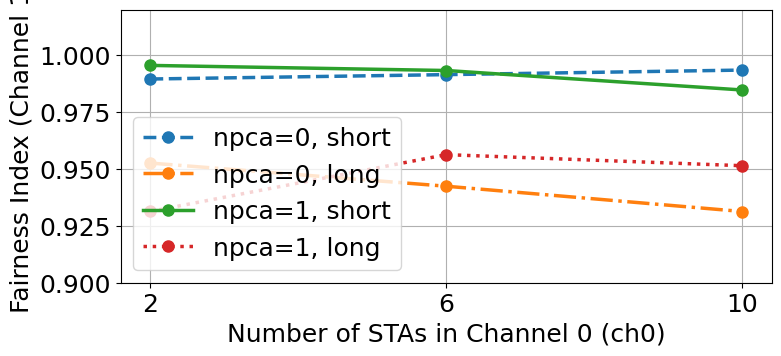

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.size": 18,           # 글꼴 크기
    "lines.linewidth": 2.5,    # 선 굵기 ← 이 줄 추가
    "lines.markersize": 8      # 마커 크기도 같이 조절 가능 (선택)
})

df_fairness = pd.read_csv("combined_metrics_summary.csv")

# Step 6: Plotting (Channel 0 기준)
colors = {2: 'blue', 6: 'green', 10: 'red'}
styles = {
    0: {"short": "dashed", "long": "dashdot"},
    1: {"short": "solid", "long": "dotted"},
}

# 유일한 ch1 값 목록
unique_ch1_values = sorted(df_fairness["ch1"].unique())

# 각 ch1 값에 대해 개별 plot 출력
for ch1_val in unique_ch1_values:
    fig, ax = plt.subplots(figsize=(8, 4))

    for npca in [0, 1]:
        for frame in ["short", "long"]:
            subset = df_fairness[
                (df_fairness["ch1"] == ch1_val) &
                (df_fairness["npca"] == npca) &
                (df_fairness["frame"] == frame)
            ].sort_values("ch0")
            if not subset.empty:
                label = f"npca={npca}, {frame}"
                ax.plot(subset["ch0"], subset["fairness_ch1"],
                        label=label,
                        linestyle=styles[npca][frame],
                        marker='o')
    ax.set_xticks(subset["ch0"].unique())
    # ax.set_title(f"Jain's Fairness Index on Channel 0\n(STA in ch0 = {ch0_val})")
    ax.set_xlabel("Number of STAs in Channel 0 (ch0)")
    ax.set_ylabel("Fairness Index (Channel 1)")
    ax.set_ylim(0.9, 1.02)
    ax.grid(True)
    ax.legend()
    plt.tight_layout()
    plt.savefig(f"plots/jain_fairness_ch1_{ch1_val}.eps")